In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

plt.style.use("seaborn-v0_8")
DATA_PATH = Path("../data/ts2024.csv")

# --- Load and preprocess ---
df = pd.read_csv(DATA_PATH)
df["DateTime_fixed"] = df["DateTime"].apply(lambda x: x if " " in x else f"{x} 00:00:00")
df["DateTime"] = pd.to_datetime(df["DateTime_fixed"], errors="coerce")
df.drop(columns=["DateTime_fixed"], inplace=True)
df["Date"] = df["DateTime"].dt.date
df["Hour"] = df["DateTime"].dt.hour

H = 744
test  = df.iloc[-H:]
valid = df.iloc[-2*H:-H]
train = df.iloc[:-2*H]


In [2]:

SEASON_LIST = [{"period": 24, "harmonics": 12}]
MODEL_A = dict(level="local linear trend", freq_seasonal=SEASON_LIST)

def fit_ucm(endog, model_kwargs, exog=None):
    return UCM(endog, exog=exog, **model_kwargs).fit(disp=False)

def forecast_and_score(fit_res, steps, truth=None):
    pred = fit_res.forecast(steps=steps)
    if truth is not None:
        mask = truth.notna()
        mae = mean_absolute_error(truth[mask].values, pred.values[mask])
    else:
        mae = None
    return pred, mae


In [3]:

fit_A = fit_ucm(train["X"], model_kwargs=MODEL_A)
print("Model A fitted.")
print(fit_A.summary())

pred_valid_A, mae_valid_A = forecast_and_score(fit_A, H, truth=valid["X"])
print(f"Validation MAE (Model A): {mae_valid_A:.4f}")

trainval = pd.concat([train, valid])
fit_A_final = fit_ucm(trainval["X"], model_kwargs=MODEL_A)

forecast_all = fit_A_final.forecast(steps=len(test))
test_clean = test[["X"]].copy()
test_clean["UCM"] = forecast_all.values


Model A fitted.
                                Unobserved Components Results                                 
Dep. Variable:                                      X   No. Observations:                16056
Model:                             local linear trend   Log Likelihood               30915.008
                   + stochastic freq_seasonal(24(12))   AIC                         -61822.016
Date:                                Sat, 12 Jul 2025   BIC                         -61791.287
Time:                                        17:38:44   HQIC                        -61811.853
Sample:                                             0                                         
                                              - 16056                                         
Covariance Type:                                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [4]:

weekly_model = dict(level="local linear trend", freq_seasonal=[{"period": 7, "harmonics": 3}])
residuals_hourly = []
preds_test = []
preds_valid = []
mae_valid_B_by_hour = []

for h in range(24):
    trainval_h = trainval[trainval["Hour"] == h]
    test_h = test[test["Hour"] == h]
    valid_h = valid[valid["Hour"] == h]

    fit_h = UCM(trainval_h["X"], **weekly_model).fit(disp=False)

    pred_test = fit_h.forecast(steps=len(test_h))
    preds_test.append(pd.Series(pred_test.values, index=test_h.index))

    pred_valid = fit_h.forecast(steps=len(valid_h))
    preds_valid.append(pd.Series(pred_valid.values, index=valid_h.index))

    mask = valid_h["X"].notna()
    if mask.sum() > 0:
        mae_h = mean_absolute_error(valid_h["X"][mask].values, pred_valid.values[mask])
        mae_valid_B_by_hour.append(mae_h)
    residuals_hourly.append(trainval_h["X"] - fit_h.fittedvalues)

valid["UCM_hourly"] = pd.concat(preds_valid).sort_index()
test["UCM_hourly"] = pd.concat(preds_test).sort_index()

mae_valid_B = mean_absolute_error(valid["X"].dropna(), valid["UCM_hourly"].loc[valid["X"].notna()])
print(f"Validation MAE (Model B Hourly): {mae_valid_B:.4f}")


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Utente\time series\venv\

Validation MAE (Model B Hourly): 0.0251


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C

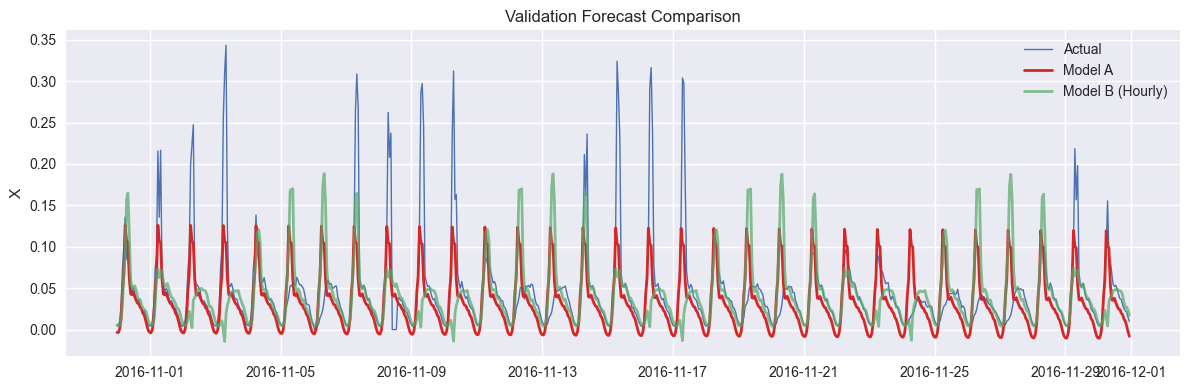

In [5]:

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(valid["DateTime"], valid["X"], label="Actual", lw=1)
ax.plot(valid["DateTime"], pred_valid_A, label="Model A", lw=2, color="tab:red")
ax.plot(valid["DateTime"], valid["UCM_hourly"], label="Model B (Hourly)", lw=2, alpha=0.7)
ax.set(title="Validation Forecast Comparison", ylabel="X")
ax.legend()
plt.tight_layout()
plt.show()


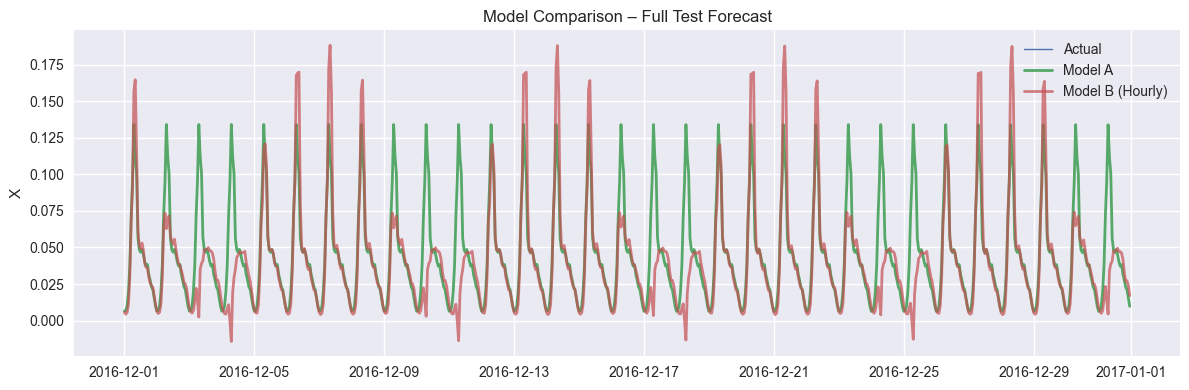

In [6]:

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(test["DateTime"], test["X"], label="Actual", lw=1)
ax.plot(test["DateTime"], test_clean["UCM"], label="Model A", lw=2)
ax.plot(test["DateTime"], test["UCM_hourly"], label="Model B (Hourly)", lw=2, alpha=0.7)
ax.set(title="Model Comparison – Full Test Forecast", ylabel="X")
ax.legend()
plt.tight_layout()
plt.show()


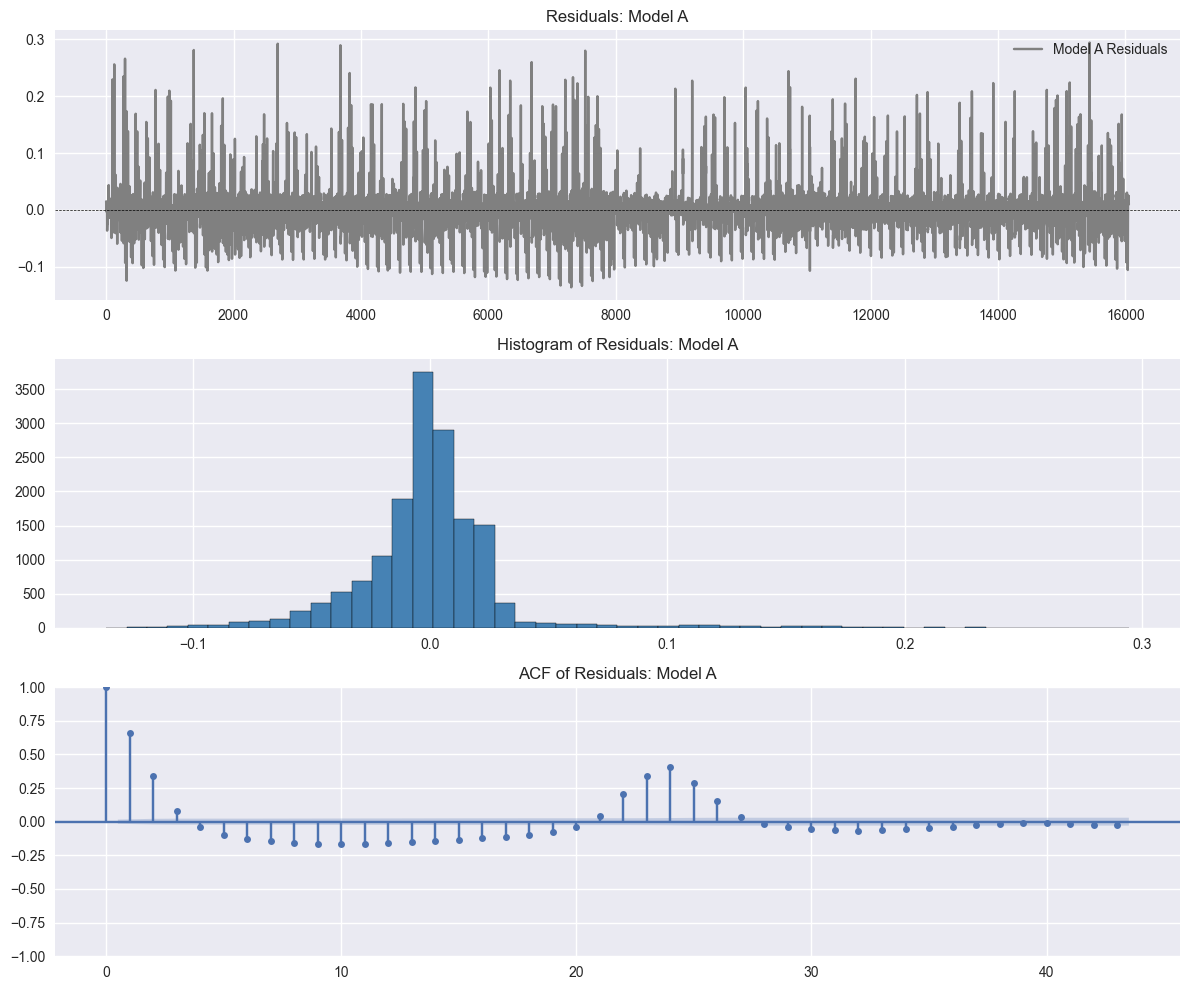

In [7]:

# Residual diagnostics for Model A
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=False)

axs[0].plot(fit_A.resid, label="Model A Residuals", color="gray")
axs[0].axhline(0, linestyle="--", color="black", lw=0.5)
axs[0].legend()
axs[0].set_title("Residuals: Model A")

axs[1].hist(fit_A.resid.dropna(), bins=50, color="steelblue", edgecolor="black")
axs[1].set_title("Histogram of Residuals: Model A")

plot_acf(fit_A.resid.dropna(), ax=axs[2])
axs[2].set_title("ACF of Residuals: Model A")

plt.tight_layout()
plt.show()


In [8]:

output = test.copy()
output["UCM"] = test_clean["UCM"]
output.to_csv("../data/ts2024_test_forecast_ucm.csv", index=False)
print("Saved test forecast with UCM → ../data/ts2024_test_forecast_ucm.csv")


Saved test forecast with UCM → ../data/ts2024_test_forecast_ucm.csv
